In [19]:
from glob import glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from dataloader import MultiStreamLoader, concat_variable_length_files, get_data_loader, complex_tensor_to_audio

import torch
from torch import nn
from torch import optim

from model import UNet

from tensorboardX import SummaryWriter

In [12]:
writer = SummaryWriter()

In [13]:
wav_files = sorted(glob('./data/background/YD/*.wav'))
background_stream_loader = MultiStreamLoader(wav_files)

speech_files = sorted(glob('./data/speech/KSS/*/*.wav'))
before_folding = len(speech_files)
speech_files = concat_variable_length_files(speech_files)
print(f'{before_folding:5} => {len(speech_files):5}')

background_stream_loader = MultiStreamLoader(wav_files)
dataloader = get_data_loader([f[0] for f in speech_files], background_stream_loader)

100%|██████████| 12854/12854 [00:04<00:00, 2582.00it/s]

12854 =>  6531


In [ ]:
'''
Our implementation of U-Net is similar to that of [11]. 
Each encoder layer consists of a strided 2D convolution of stride 2 and kernel size 5x5, 
batch normalization, and leaky rectified linear units (ReLU) with leakiness 0.2. 
In the decoder we use strided deconvolution (sometimes referred to as transposed convolution) 
with stride 2 and kernel size 5x5, batch normalization, plain ReLU, 
and use 50% dropout to the first three layers, as in [11]. 
In the final layer we use a sigmoid activation function. 
The model is trained using the ADAM [12] optimizer.
'''


l1_loss = nn.L1Loss(reduction='mean')
l2_loss = nn.MSELoss(reduction='mean')

model = UNet()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

for i in range(100):

    for i, batch in enumerate(dataloader):
        Zxxs, log_spectrograms = batch

        # Zxxs[0].shape
        # torch.Size([4, 321, 1025, 2])
        # log_spectrograms[0].shape
        # torch.Size([4, 321, 1025])
        signal, noise, mixed = log_spectrograms

        output = model(mixed)
        loss1 = l1_loss(output, signal)
        loss2 = l2_loss(output, signal)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(loss)

In [48]:
def mel_tensor_to_plt_image(tensor_list, step):
    
    assert len(tensor_list) == 5, f'Length of tensor list is not 5 ({len(tensor_list)})'

    titles = ['Mixed', 'Speech', 'Reconstructed Speech',
              'Background', 'Reconstructed Background']
    
    fig, axes = plt.subplots(5, 1, sharey=True, figsize=(20, 15))
    fig.suptitle(f'Mel-spectrogram from Step #{step:07d}', fontsize=24, y=0.95)
    axes = axes.flatten()
    for i in range(5):
        im = axes[i].imshow(tensor_list[i].T, origin='lower', aspect='auto')
        im.set_clim(0, 1)
        axes[i].axes.xaxis.set_visible(False)
        axes[i].axes.yaxis.set_visible(False)
        axes[i].set_title(titles[i])
    fig.colorbar(im, ax=axes, location='right')
    fig.canvas.draw()

    image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    image_array = np.swapaxes(image_array, 0, 2)
    image_array = np.swapaxes(image_array, 1, 2)

    # plt.show()
    plt.close()

    return image_array

In [63]:
tensor_list = [mixed[0, 0], signal[0, 0], output[0, 0].detach(),
               noise[0, 0], signal[0, 0]]

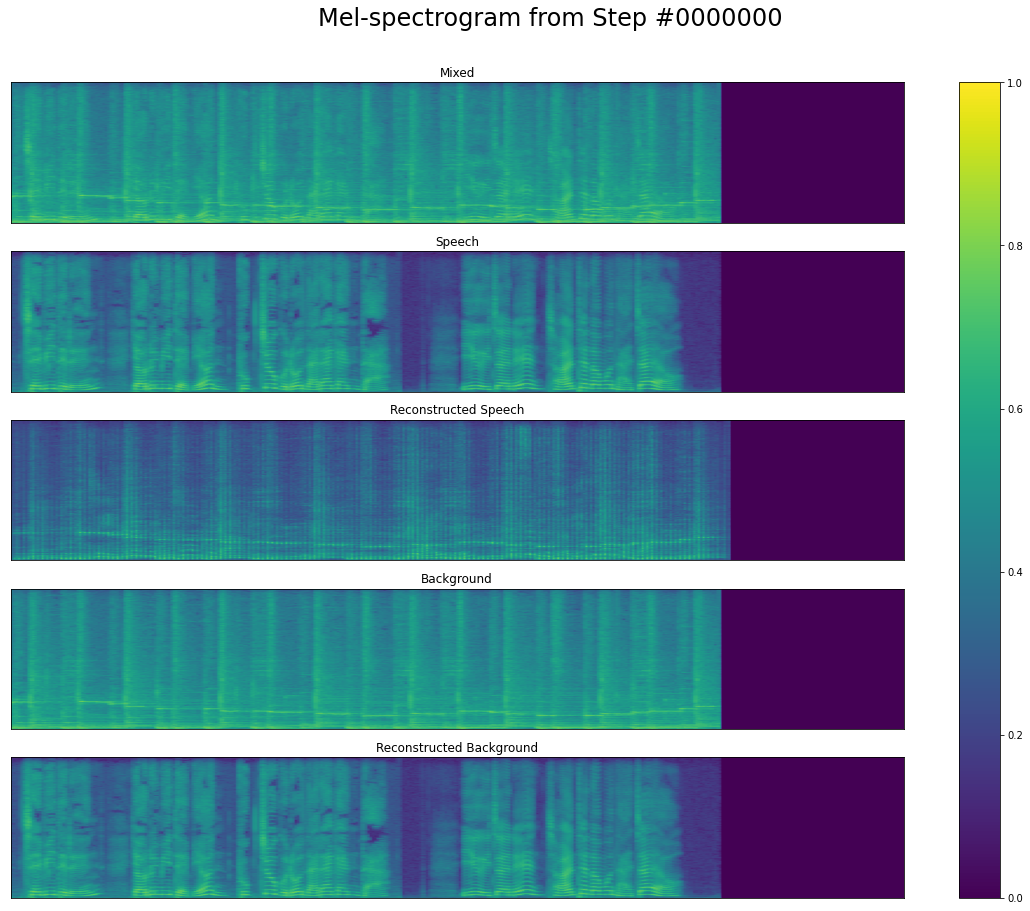

In [64]:
image = mel_tensor_to_plt_image(tensor_list, 0)

In [65]:
import matplotlib
matplotlib.use('agg')

In [21]:
y_ = complex_tensor_to_audio(Zxxs[0])

In [ ]:
logging_image = mel_tensor_to_plt_image(mel_tensor, decoded_input_text, train_step)
writer.add_image('input_spectrogram/test', logging_image, train_step)